# Machine Learning Boilerplate Project

This notebook is designed to provide a structured and modular framework for building, evaluating, and testing machine learning models. It simplify the typical machine learning pipeline, including data preprocessing, cross-validation, and evaluation.

<center><h1>Dataset</h1></center>

## Define File Path and Parameters

Before starting, configure the following parameters to match your dataset and requirements:

- **FILE_PATH**: Path to the CSV file containing your dataset.
- **TARGET_COL**: Name of the target column in your dataset (i.e., the variable you want to predict).
- **RANDOM_SEED**: Random seed to ensure reproducibility across different runs.

In [8]:
FILE_PATH = "data/data.csv"  # replace with the path to your CSV file
TARGET_COL = "target"  # replace with the name of your target column
RANDOM_SEED = 42  # random seed for reproducibility

## Load Dataset and Extract Features

This section is responsible for loading the dataset and preparing the features (`X`) and target (`y`) variables. By the end of this step, the dataset is ready for further preprocessing and modeling. 

In [ ]:
import pandas as pd

try:
    data = pd.read_csv(FILE_PATH)
    print(f"Data successfully loaded from {FILE_PATH}.")
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {FILE_PATH}")

try:
    X = data.drop(columns=[TARGET_COL])
    y = data[TARGET_COL]
    print(f"Features (X) shape: {X.shape}")
    print(f"Target (y) shape: {y.shape}")
except KeyError:
    raise KeyError(f"Target column '{TARGET_COL}' not found in the dataset.")

# Using Scikit-Learn's Toy Datasets for Machine Learning

## Overview

Scikit-learn provides several **toy datasets** that are readily available for practicing machine learning techniques. These datasets are small, clean, and designed for educational purposes, making them perfect for building and testing machine learning models. In this project, we will use two popular toy datasets:

- **Iris Dataset**: For classification tasks.
- **Diabetes Dataset**: For regression tasks.

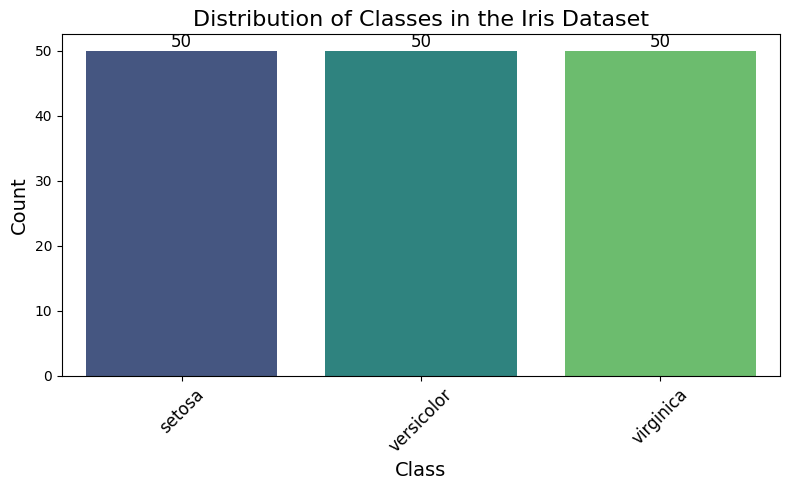

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import pandas as pd

data = load_iris()
X = pd.DataFrame(data=data.data, columns=data.feature_names)
y = data.target

class_names = [data.target_names[label] for label in y]

plt.figure(figsize=(8, 5))
sns.countplot(x=class_names, palette='viridis')

for i, v in enumerate(pd.Series(class_names).value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Classes in the Iris Dataset', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()



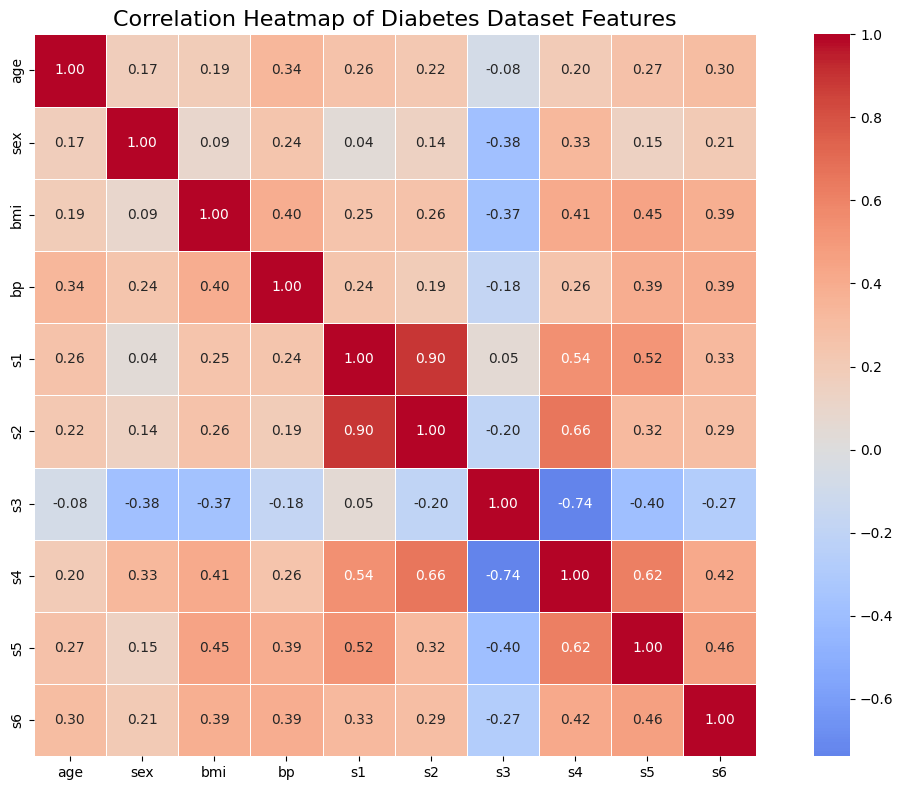

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
import pandas as pd

data = load_diabetes()
X = pd.DataFrame(data=data.data, columns=data.feature_names)
y = data.target

correlation_matrix = X.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm',
            center=0, 
            fmt='.2f', 
            square=True, 
            linewidths=0.5) 

plt.title('Correlation Heatmap of Diabetes Dataset Features', fontsize=16)
plt.tight_layout()
plt.show()

<center><h1>Data Pre-processing</h1></center>

## One-Hot Encoding for Categorical Features

In this section, one-hot encoding is applied directly to the categorical features in the dataset. This technique transforms categorical variables into a binary matrix, where each unique category is represented by a binary column.

### Steps:
1. **Select Categorical Columns**: Identify the columns in the dataset that contain categorical data.
2. **One-Hot Encoding**: Use the `OneHotEncoder` from `sklearn` to transform the categorical columns into binary features.
3. **Merge Encoded Data**: Replace the original categorical columns with their encoded counterparts in the dataset.

This ensures that the categorical features are properly represented for machine learning algorithms.


In [62]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

categorical_columns = X.select_dtypes(include=['object', 'category']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_columns])
encoded_columns = encoder.get_feature_names_out(categorical_columns)
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_columns, index=X.index)
X = pd.concat([X.drop(columns=categorical_columns), X_encoded_df], axis=1)

if y.dtype in ['object', 'category']:
    if len(y.unique()) > 2:
        encoder_y = OneHotEncoder(sparse_output=False)
        y_encoded = encoder_y.fit_transform(y.values.reshape(-1, 1))
        encoded_columns_y = encoder_y.get_feature_names_out([TARGET_COL])
        y = pd.DataFrame(y_encoded, columns=encoded_columns_y, index=y.index)
    else:
        encoder_y = LabelEncoder()
        y = pd.Series(encoder_y.fit_transform(y), index=y.index)

## Handle Missing Values

This section implements a comprehensive strategy for dealing with missing values in the dataset. The approach follows best practices in data preprocessing and includes multiple handling methods based on the nature and extent of missingness.

### Missing Value Analysis
First, we create a summary of missing values across all columns, including:
- Total count of missing values per column
- Percentage of missing values per column

### Handling Strategy
The code implements different strategies based on two key factors:
1. **Percentage of Missing Values**:
  - 0%: No action needed
  - \>70%: Drop the column entirely
  - 5-70%: Create missing indicator + imputation  
  - <5%: Simple imputation

2. **Data Type**:
  - **Numerical Columns**:
    - Imputation using median values
    - Missing indicators for columns with >5% missing
  
  - **Categorical Columns**:
    - Imputation using mode (most frequent value) for low missingness
    - Imputation with 'Missing' category for higher missingness
    - Missing indicators for columns with >5% missing

### Quality Control
The section includes verification steps:
- Prints the dataset shape before and after handling missing values
- Updates the feature matrix (X) and target vector (y)
- Includes an assertion to verify that no missing values remain in the dataset

This approach ensures robust handling of missing data while preserving important information about missingness patterns through indicator variables.

In [63]:
missing_stats = pd.DataFrame({
    'Total Missing': X.isnull().sum(),
    'Percent Missing': (X.isnull().sum() / len(X) * 100).round(2)
})
missing_stats[missing_stats['Total Missing'] > 0].sort_values('Percent Missing', ascending=False)

if len(missing_stats) > 0:
    print("Missing Value Statistics:")
    print(missing_stats)
    print("\nShape before handling missing values:", X.shape)
    
    for column in X.columns:
        missing_pct = (X[column].isnull().sum() / len(X)) * 100
        
        if missing_pct == 0:
            continue
        
        elif missing_pct > 70:
            X = X.drop(columns=[column])
            print(f"\nDropped column '{column}' with {missing_pct:.1f}% missing values")
        
        elif pd.api.types.is_numeric_dtype(X[column]):
            if missing_pct < 5:
                X[column] = X[column].fillna(X[column].median())
                print(f"\nImputed '{column}' with median")
            else:
                X[f'{column}_missing'] = X[column].isnull().astype(int)
                X[column] = X[column].fillna(X[column].median())
                print(f"\nCreated missing indicator and imputed '{column}' with median")
        
        else:
            if missing_pct < 5:
                X[column] = X[column].fillna(X[column].mode()[0])
                print(f"\nImputed '{column}' with mode")
            else:
                X[f'{column}_missing'] = X[column].isnull().astype(int)
                X[column] = X[column].fillna('Missing')
                print(f"\nCreated missing indicator and imputed '{column}' with 'Missing' category")
    
    print("\nShape after handling missing values:", X.shape)
    
else:
    print("No missing values found in the dataset.")

assert X.isnull().sum().sum() == 0, "Missing values still present in the dataset"

Missing Value Statistics:
                   Total Missing  Percent Missing
sepal length (cm)              0              0.0
sepal width (cm)               0              0.0
petal length (cm)              0              0.0
petal width (cm)               0              0.0

Shape before handling missing values: (150, 4)

Shape after handling missing values: (150, 4)


## Model Selection: Classification and Regression

This section defines the models that will be used in the pipeline. Different models are provided to support both classification and regression tasks, depending on the type of problem you are solving.

### Classification Models
- **Random Forest Classifier**
- **Support Vector Classifier (SVC)**
- **XGBoost Classifier**
- **MLP Classifier**

### Regression Models
- **Linear Regression**
- **Ridge Regression**
- **Random Forest Regressor**
- **Support Vector Regressor (SVR)**
- **Gradient Boosting Regressor**

### Hyperparameter Optimization
For each model, a predefined grid of hyperparameters is provided to facilitate tuning using cross-validation. Adjust the hyperparameters as needed for your specific use case, depending on the dataset and computational resources.

By selecting and fine-tuning these models, you can evaluate their performance and determine the best approach for your problem.

In [64]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=RANDOM_SEED)

grid_params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 20],
}

In [ ]:
from sklearn.svm import SVC

model = SVC(random_state=RANDOM_SEED)

grid_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto'],
}

In [3]:
import xgboost as xgb

model = xgb.XGBClassifier(random_state=RANDOM_SEED)

grid_params = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0],
}

In [4]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(random_state=RANDOM_SEED)

grid_params = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__solver': ['adam', 'sgd'],
    'model__alpha': [0.0001, 0.001, 0.01],
}

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

grid_params = {
    'model__fit_intercept': [True, False],
    'model__normalize': [True, False],

In [ ]:
from sklearn.linear_model import Lasso

model = Lasso(random_state=RANDOM_SEED)

grid_params = {
    'model__alpha': [0.1, 1, 10],
    'model__max_iter': [1000, 5000],
}

In [55]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=RANDOM_SEED)

grid_params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
}

In [ ]:
from sklearn.svm import SVR

model = SVR()

grid_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf', 'poly'],
    'model__gamma': ['scale', 'auto'],
}

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=RANDOM_SEED)

grid_params = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0],
}

## Pipelines

This section defines two proposed preprocessing pipelines for preparing data before feeding it into the model. Both pipelines aim to normalize the data and perform dimensionality reduction or feature selection, depending on the requirements of the task.

### Notes
These pipelines are modular, allowing you to replace the classifier (`model`) with any supported model. Choose the pipeline based on the nature of your dataset and the specific goals of your analysis.

### Pipeline 1: Feature Selection with `SelectKBest`
1. **Normalization**: Uses `StandardScaler` to normalize the data.
2. **Feature Selection**: Selects the top `NUM_SELECTED_FEATURES` (default: 10) using ANOVA F-statistic (`SelectKBest` with `f_classif`).
3. **Classification**: The selected features are passed to the chosen model.

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

NUM_SELECTED_FEATURES = 2

pipeline = Pipeline([
    ('scaler', StandardScaler()),                                            
    ('feature_selection', SelectKBest(f_classif,
                                      k=NUM_SELECTED_FEATURES)),  
    ('model', model)                                                    
])

### Pipeline 2: Dimensionality Reduction with `PCA`
1. **Normalization**: Uses `StandardScaler` to normalize the data.
2. **Principal Component Analysis (PCA)**: Reduces the dimensionality of the data, retaining `VARIANCE` (default: 95%) of the original variance.
3. **Classification**: The transformed features are passed to the chosen model.

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

VARIANCE = 0.95

pipeline = Pipeline([
    ('scaler', StandardScaler()),         
    ('pca', PCA(n_components=VARIANCE)),  
    ('model', model)                 
])

## Configure Train-Test Splits

Define the proportions and parameters for splitting the dataset into training and testing sets:

- **TRAIN_SIZE**: Proportion of the dataset to be used for training in each split (e.g., 0.8 indicates 80% for training and 20% for testing).
- **NUM_SPLITS**: Number of splits to perform during cross-validation.

These parameters allow you to control the size and frequency of the train-test splits, ensuring robust evaluation of the models.

In [16]:
TRAIN_SIZE = 0.8  
NUM_FOLD = 5    

<center><h1>Classification</h1></center>

## Model Training and Hyperparameter Tuning

This section involves splitting the dataset, performing hyperparameter tuning using cross-validation, and evaluating the best model on the test set.

### Train-Test Split
- The dataset is split into training and testing sets using `train_test_split` with a stratified split to maintain the class distribution.
- The `TRAIN_SIZE` parameter defines the proportion of data used for training.

### Hyperparameter Tuning with Grid Search
- A `GridSearchCV` object is used to tune the hyperparameters of the pipeline.
- Cross-validation is performed with `NUM_FOLD` splits to find the best combination of hyperparameters.
- The results of the cross-validation, including mean and standard deviation of accuracy scores for each parameter set, are displayed.

In [66]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=TRAIN_SIZE, 
                                                    stratify=y, 
                                                    random_state=RANDOM_SEED)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=grid_params,
                           scoring='accuracy',
                           cv=NUM_FOLD,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

cv_results = pd.DataFrame(grid_search.cv_results_)
mean_cv_scores = cv_results['mean_test_score']
std_cv_scores = cv_results['std_test_score']

print("Cross-Validation Results:")
for i, (mean, std) in enumerate(zip(mean_cv_scores, std_cv_scores)):
    print(f"Parameter set {i+1}: Mean Accuracy = {mean:.4f}, Std = {std:.4f}")

Cross-Validation Results:
Parameter set 1: Mean Accuracy = 0.9417, Std = 0.0204
Parameter set 2: Mean Accuracy = 0.9500, Std = 0.0167
Parameter set 3: Mean Accuracy = 0.9500, Std = 0.0167
Parameter set 4: Mean Accuracy = 0.9417, Std = 0.0204
Parameter set 5: Mean Accuracy = 0.9500, Std = 0.0167
Parameter set 6: Mean Accuracy = 0.9500, Std = 0.0167
Parameter set 7: Mean Accuracy = 0.9417, Std = 0.0204
Parameter set 8: Mean Accuracy = 0.9500, Std = 0.0167
Parameter set 9: Mean Accuracy = 0.9500, Std = 0.0167


## Model Evaluation on Test Data
- The best pipeline from the grid search is used to predict the test set.
- Evaluation metrics include:
  - **Accuracy**: Overall performance of the model.
  - **Classification Report**: Precision, recall, F1-score, and support for each class.
  - **Confusion Matrix**: Breakdown of true positives, true negatives, false positives, and false negatives.

By following this process, you can select the best model configuration and validate its performance on unseen data.


Test Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



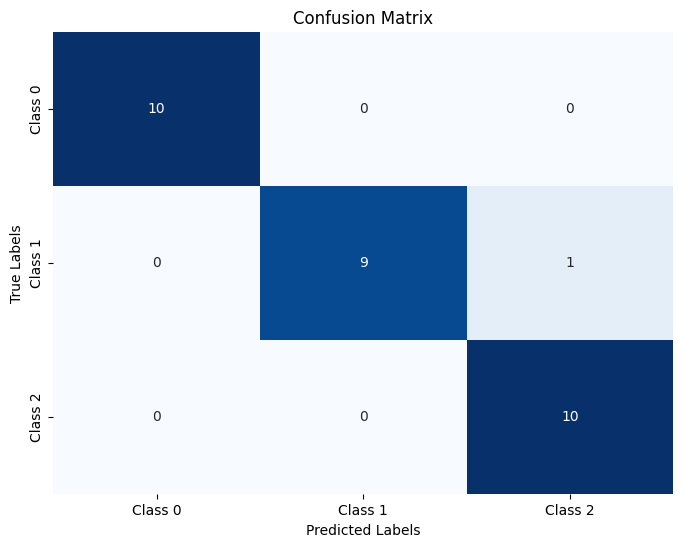

In [68]:
y_pred = best_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[f"Class {i}" for i in range(len(conf_matrix))],
            yticklabels=[f"Class {i}" for i in range(len(conf_matrix))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<center><h1>Regression</h1></center>

## Model Training and Hyperparameter Tuning

This section focuses on splitting the dataset, performing hyperparameter tuning using cross-validation, and evaluating the best model on the test set for regression tasks.

### Train-Test Split
- The dataset is split into training and testing sets using `train_test_split`.
- The `TRAIN_SIZE` parameter specifies the proportion of data to use for training.

### Hyperparameter Tuning with Grid Search
- A `GridSearchCV` object is used to perform hyperparameter tuning for the pipeline.
- Cross-validation is conducted with `NUM_FOLD` splits to identify the optimal hyperparameter configuration.
- The mean and standard deviation of the negative Mean Squared Error (MSE) for each parameter set are reported. Negative MSE is converted to positive for interpretability.

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=TRAIN_SIZE, 
                                                    random_state=RANDOM_SEED)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=grid_params,
                           scoring='neg_mean_squared_error',  # Use a regression metric
                           cv=NUM_FOLD,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

cv_results = pd.DataFrame(grid_search.cv_results_)
mean_cv_scores = -cv_results['mean_test_score'] 
std_cv_scores = cv_results['std_test_score']

print("Cross-Validation Results:")
for i, (mean, std) in enumerate(zip(mean_cv_scores, std_cv_scores)):
    print(f"Parameter set {i+1}: Mean MSE = {mean:.4f}, Std = {std:.4f}")

Cross-Validation Results:
Parameter set 1: Mean MSE = 3604.6588, Std = 430.3340
Parameter set 2: Mean MSE = 3592.1807, Std = 421.3169
Parameter set 3: Mean MSE = 3558.5029, Std = 406.4049
Parameter set 4: Mean MSE = 3630.7768, Std = 415.4881
Parameter set 5: Mean MSE = 3617.7528, Std = 419.2876
Parameter set 6: Mean MSE = 3570.8728, Std = 403.9741
Parameter set 7: Mean MSE = 3605.1980, Std = 461.2498
Parameter set 8: Mean MSE = 3612.4569, Std = 444.7053
Parameter set 9: Mean MSE = 3589.9191, Std = 420.8817
Parameter set 10: Mean MSE = 3649.8723, Std = 393.9413
Parameter set 11: Mean MSE = 3613.6953, Std = 364.9895
Parameter set 12: Mean MSE = 3606.2818, Std = 373.1545
Parameter set 13: Mean MSE = 3661.1419, Std = 441.3549
Parameter set 14: Mean MSE = 3617.2304, Std = 391.6460
Parameter set 15: Mean MSE = 3599.0856, Std = 380.6071
Parameter set 16: Mean MSE = 3624.9045, Std = 445.5620
Parameter set 17: Mean MSE = 3622.9167, Std = 398.6624
Parameter set 18: Mean MSE = 3611.3594, Std = 38

## Model Evaluation on Test Data

- The best pipeline from the grid search is used to predict the test set.
- Evaluation metrics include:
  - **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values. Lower values indicate better model performance.
  - **Mean Absolute Error (MAE)**: Measures the average absolute difference between predicted and actual values, providing an interpretable error metric in the same unit as the target variable.
  - **R² Score**: Represents the proportion of variance in the target variable explained by the model. Values closer to 1 indicate a better fit.

This process allows for a thorough assessment of the model’s performance on unseen data, ensuring the selected pipeline provides reliable predictions for regression tasks.

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nTest Mean Squared Error (MSE): {mse:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")
print(f"Test R² Score: {r2:.4f}")


Test Mean Squared Error (MSE): 2845.9055
Test Mean Absolute Error (MAE): 43.1295
Test R² Score: 0.4628
